# Energy Consumption Prediction in Steel Industry using AI/ML Models
Based on the dataset from UCI ML Repository (ID: 851) and inspired by the given abstract.

I explored multiple ML models to predict energy consumption using features such as power factor, load types, and CO₂ emissions.

After evaluation and comparison, it showed that XGBoost and Random Forest outperformed others due to handling non-linear relationships.

So, XGBoost was deployed in this model to be use in the industry for energy consumption prediction.

# Install UCIMLREPO

In [ ]:
pip install ucimlrepo

# Import Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from ucimlrepo import fetch_ucirepo

In [ ]:
# Load dataset
steel_industry_energy_consumption = fetch_ucirepo(id=851)

In [ ]:
# Combine features and targets into a single DataFrame initially
df = pd.concat([steel_industry_energy_consumption.data.features, steel_industry_energy_consumption.data.targets], axis=1)

In [ ]:
print(steel_industry_energy_consumption.data.keys())

dict_keys(['ids', 'features', 'targets', 'original', 'headers'])


In [ ]:
# Verify column names after combining
print("Actual columns in combined dataset:")
print(df.columns.tolist())

Actual columns in combined dataset:
['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'WeekStatus', 'Day_of_week', 'Load_Type']


# Feature Engineering

In [ ]:
# Convert seconds to hours and handle temporal features
df['Hour'] = df['NSM'] // 3600  # Convert seconds to hours
df['Day_of_week'] = df['Day_of_week'].astype('category')
df['WeekStatus'] = df['WeekStatus'].astype('category')

In [ ]:
# Prepare data - Define features (X) and target (y)
# Drop 'Usage_kWh' and 'Load_Type' from features (X)
X = df.drop(['Usage_kWh', 'Load_Type'], axis=1)
y = df['Usage_kWh'] # Explicitly select 'Usage_kWh' as the target

In [ ]:
# Convert categoricals to dummy variables
X = pd.get_dummies(X, columns=['Day_of_week', 'WeekStatus']) # 'Load_Type' is now dropped from X

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training & Evaluation

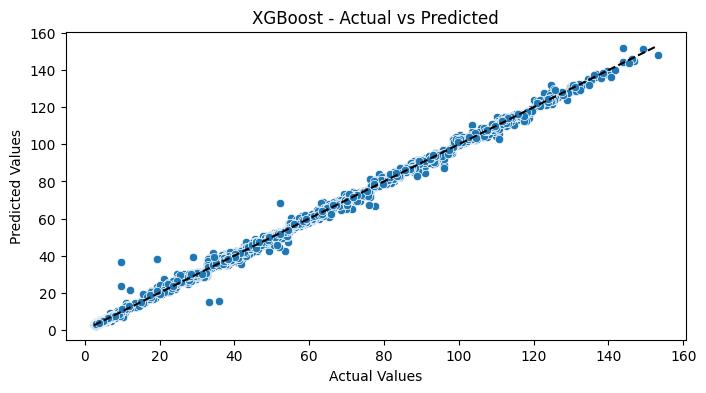

In [ ]:
models = {"XGBoost": XGBRegressor(random_state=42)}

results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Start of metric calculation and appending (moved here)
    metrics = {
        'Model': name,
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R²': r2_score(y_test, y_pred)
    }
    results.append(metrics)
    # End of metric calculation and appending

    # Start of Actual vs Predicted plot (can remain here or be moved after the loop)
    plt.figure(figsize=(8,4))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.title(f'{name} - Actual vs Predicted')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    # Adjust the plot line to the range of the target variable
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.show()
    # End of Actual vs Predicted plot

# Feature Importance for tree-based models

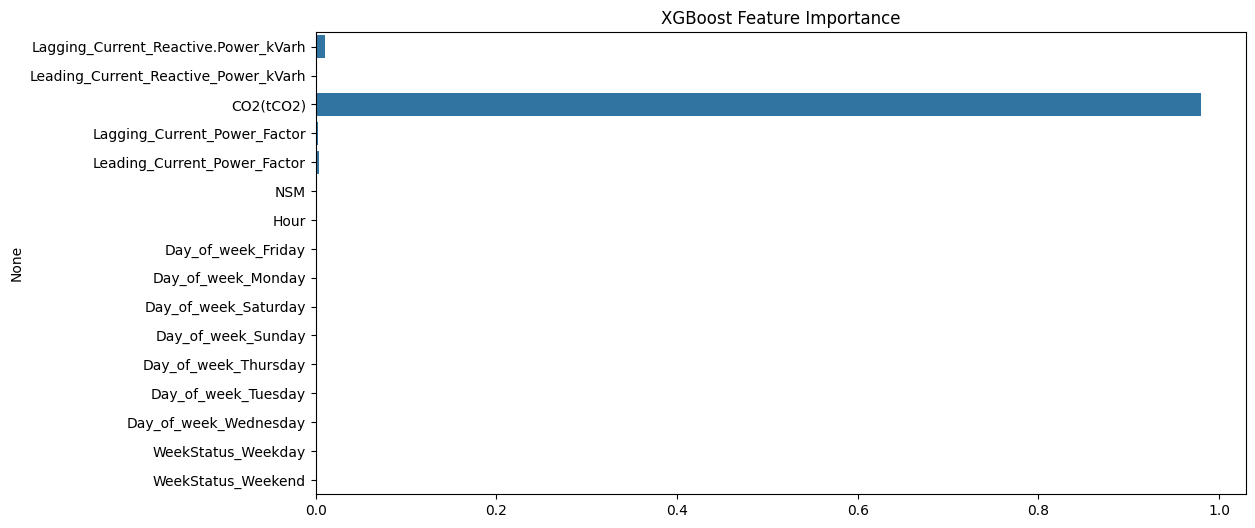

In [ ]:
for name in ["XGBoost"]:
    # Check if the model supports feature_importances_
    if hasattr(models[name], 'feature_importances_'):
        importances = models[name].feature_importances_
        features = X.columns

        plt.figure(figsize=(12,6))
        sns.barplot(x=importances, y=features)
        plt.title(f'{name} Feature Importance')
        plt.show()
    else:
        print(f"{name} does not support feature importance.")

# Results

In [ ]:
results_df = pd.DataFrame(results)
print(results_df.sort_values('RMSE'))

     Model       MAE      RMSE        R²
0  XGBoost  0.479701  1.093364  0.998948


# Visualization

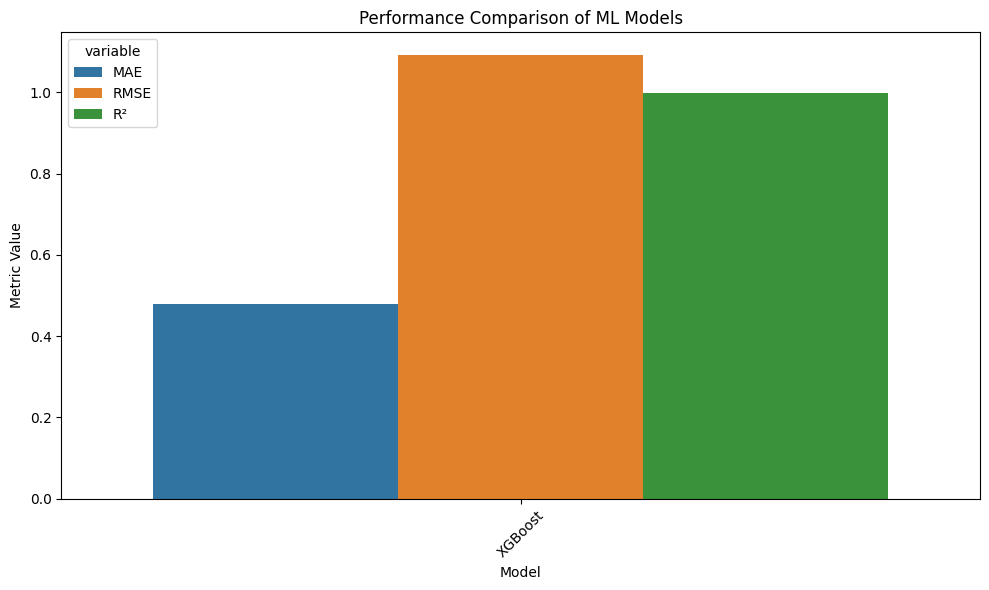

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.xticks(rotation=45)
plt.title('Performance Comparison of ML Models')
plt.ylabel('Metric Value')
plt.tight_layout()
plt.show()

In [ ]:

import joblib

# Save model and scaler separately
joblib.dump(model, 'energy_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [ ]:
# Save feature names/order
with open('feature_names.txt', 'w') as f:
    f.write(','.join(X.columns))

In [ ]:
print("Model and scaler saved successfully.")

Model and scaler saved successfully.
